# 11 - Tabula Muris Data Preparation

This notebook prepares Tabula Muris (10x droplet) data for cross-dataset validation.

**Goal:** Apply same preprocessing as PBMC-33k to enable direct comparison.

**Data source:** [Figshare - Single-cell RNA-seq data from microfluidic emulsion](https://figshare.com/articles/dataset/5968960)

**Paper:** [Single-cell transcriptomics of 20 mouse organs creates a Tabula Muris](https://doi.org/10.1038/s41586-018-0590-4)

Steps:
1. Load all tissue samples (24 filtered runs)
2. Merge with cell annotations
3. QC filtering (same thresholds as PBMC)
4. Normalization and HVG selection (2000 genes)
5. Clustering and rare cell type identification
6. Save processed data

In [1]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path
import os

from utils import set_global_seed, GLOBAL_SEED, Timer

set_global_seed(GLOBAL_SEED)

sc.settings.verbosity = 2
sc.settings.n_jobs = 1

DATA_DIR = Path('../data')
DROPLET_DIR = DATA_DIR / 'tabula_muris_droplet' / 'droplet'
ANNOTATIONS_PATH = DATA_DIR / 'annotations_droplet.csv'
PROCESSED_PATH = DATA_DIR / 'tabula_muris_processed.h5ad'

# Samples to exclude (unfiltered 10x data with all 737k barcodes)
EXCLUDE_SAMPLES = ['Lung-10X_P8_12', 'Lung-10X_P8_13', 'Trachea-10X_P8_14', 'Trachea-10X_P8_15']

print(f"Global seed: {GLOBAL_SEED}")
print(f"Droplet data dir: {DROPLET_DIR}")

Global seed: 42
Droplet data dir: ../data/tabula_muris_droplet/droplet


## 1. Load All Tissue Samples

The Tabula Muris droplet data contains 28 runs from different tissues.
Each run is in 10x format (barcodes.tsv, genes.tsv, matrix.mtx).

**Note:** 4 samples (P8) have unfiltered barcodes and are excluded.

In [2]:
# List all tissue folders
tissue_folders = sorted([
    d for d in os.listdir(DROPLET_DIR) 
    if os.path.isdir(DROPLET_DIR / d) and d not in EXCLUDE_SAMPLES
])
print(f"Found {len(tissue_folders)} filtered tissue samples (excluding {len(EXCLUDE_SAMPLES)} unfiltered):")
for t in tissue_folders:
    print(f"  {t}")

Found 24 filtered tissue samples (excluding 4 unfiltered):
  Bladder-10X_P4_3
  Bladder-10X_P4_4
  Bladder-10X_P7_7
  Heart_and_Aorta-10X_P7_4
  Kidney-10X_P4_5
  Kidney-10X_P4_6
  Kidney-10X_P7_5
  Limb_Muscle-10X_P7_14
  Limb_Muscle-10X_P7_15
  Liver-10X_P4_2
  Liver-10X_P7_0
  Liver-10X_P7_1
  Lung-10X_P7_8
  Lung-10X_P7_9
  Mammary_Gland-10X_P7_12
  Mammary_Gland-10X_P7_13
  Marrow-10X_P7_2
  Marrow-10X_P7_3
  Spleen-10X_P4_7
  Spleen-10X_P7_6
  Thymus-10X_P7_11
  Tongue-10X_P4_0
  Tongue-10X_P4_1
  Tongue-10X_P7_10


In [3]:
with Timer("Loading all tissue samples"):
    adatas = []
    for folder in tissue_folders:
        path = DROPLET_DIR / folder
        try:
            adata_tissue = sc.read_10x_mtx(path, var_names='gene_symbols', cache=True)
            # Extract tissue name from folder (e.g., "Bladder" from "Bladder-10X_P4_3")
            tissue_name = folder.split('-')[0]
            adata_tissue.obs['tissue'] = tissue_name
            adata_tissue.obs['channel'] = folder
            # Make cell barcodes unique by adding channel prefix
            adata_tissue.obs_names = [f"{folder}_{bc}" for bc in adata_tissue.obs_names]
            adatas.append(adata_tissue)
            print(f"  {folder}: {adata_tissue.n_obs} cells")
        except Exception as e:
            print(f"  {folder}: FAILED - {e}")
    
    # Concatenate all tissues
    print("\nConcatenating...")
    adata = sc.concat(adatas, join='outer')
    adata.obs_names_make_unique()

print(f"\nTotal cells: {adata.n_obs}")
print(f"Total genes: {adata.n_vars}")
print(f"\nCells per tissue:")
print(adata.obs['tissue'].value_counts())

[Loading all tissue samples] Starting at 01:15:15
... writing an h5ad cache file to speedup reading next time


  Bladder-10X_P4_3: 149 cells


... writing an h5ad cache file to speedup reading next time


  Bladder-10X_P4_4: 1783 cells


... writing an h5ad cache file to speedup reading next time


  Bladder-10X_P7_7: 568 cells


... writing an h5ad cache file to speedup reading next time


  Heart_and_Aorta-10X_P7_4: 654 cells


... writing an h5ad cache file to speedup reading next time


  Kidney-10X_P4_5: 610 cells


... writing an h5ad cache file to speedup reading next time


  Kidney-10X_P4_6: 908 cells


... writing an h5ad cache file to speedup reading next time


  Kidney-10X_P7_5: 1264 cells


... writing an h5ad cache file to speedup reading next time


  Limb_Muscle-10X_P7_14: 2242 cells


... writing an h5ad cache file to speedup reading next time


  Limb_Muscle-10X_P7_15: 2301 cells


... writing an h5ad cache file to speedup reading next time


  Liver-10X_P4_2: 1006 cells


... writing an h5ad cache file to speedup reading next time


  Liver-10X_P7_0: 596 cells
... writing an h5ad cache file to speedup reading next time


  Liver-10X_P7_1: 322 cells


... writing an h5ad cache file to speedup reading next time


  Lung-10X_P7_8: 625 cells


... writing an h5ad cache file to speedup reading next time


  Lung-10X_P7_9: 1525 cells


... writing an h5ad cache file to speedup reading next time


  Mammary_Gland-10X_P7_12: 1938 cells


... writing an h5ad cache file to speedup reading next time


  Mammary_Gland-10X_P7_13: 2543 cells


... writing an h5ad cache file to speedup reading next time


  Marrow-10X_P7_2: 1981 cells


... writing an h5ad cache file to speedup reading next time


  Marrow-10X_P7_3: 2131 cells


... writing an h5ad cache file to speedup reading next time


  Spleen-10X_P4_7: 3458 cells


... writing an h5ad cache file to speedup reading next time


  Spleen-10X_P7_6: 6115 cells


... writing an h5ad cache file to speedup reading next time


  Thymus-10X_P7_11: 1431 cells


... writing an h5ad cache file to speedup reading next time


  Tongue-10X_P4_0: 3101 cells


... writing an h5ad cache file to speedup reading next time


  Tongue-10X_P4_1: 2488 cells


... writing an h5ad cache file to speedup reading next time


  Tongue-10X_P7_10: 1949 cells

Concatenating...


[Loading all tissue samples] Completed in 25.52 seconds

Total cells: 41688
Total genes: 23433

Cells per tissue:
tissue
Spleen             9573
Tongue             7538
Limb_Muscle        4543
Mammary_Gland      4481
Marrow             4112
Kidney             2782
Bladder            2500
Lung               2150
Liver              1924
Thymus             1431
Heart_and_Aorta     654
Name: count, dtype: int64


## 2. Add Cell Annotations

Merge with official cell type annotations from the Tabula Muris consortium.

**Format mapping:**
- Our obs_names: `Tissue-Channel_Barcode-1` (e.g., `Lung-10X_P7_8_AAACGGGAGGATATAC-1`)
- Annotation cell IDs: `Channel_Barcode` (e.g., `10X_P7_8_AAACGGGAGGATATAC`)

In [4]:
# Load annotations
annotations = pd.read_csv(ANNOTATIONS_PATH, low_memory=False)
print(f"Annotations shape: {annotations.shape}")
print(f"Annotation columns: {list(annotations.columns)}")
annotations.head()

Annotations shape: (55656, 20)
Annotation columns: ['cell', 'cell_ontology_class', 'cell_ontology_id', 'channel', 'cluster.ids', 'free_annotation', 'mouse.id', 'mouse.sex', 'subsetA', 'subsetA_cluster.ids', 'subsetB', 'subsetB_cluster.ids', 'subsetC', 'subsetC_cluster.ids', 'subsetD', 'subsetD_cluster.ids', 'subtissue', 'tissue', 'tissue_tSNE_1', 'tissue_tSNE_2']


,cell,cell_ontology_class,cell_ontology_id,channel,cluster.ids,free_annotation,mouse.id,mouse.sex,subsetA,subsetA_cluster.ids,subsetB,subsetB_cluster.ids,subsetC,subsetC_cluster.ids,subsetD,subsetD_cluster.ids,subtissue,tissue,tissue_tSNE_1,tissue_tSNE_2
0,10X_P7_8_AAACGGGAGGATATAC,myeloid cell,CL:0000763,10X_P7_8,20,dendritic cells and interstital macrophages,3-F-56,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lung,17.024721,-32.902836
1,10X_P7_8_AAACGGGTCTCGTATT,alveolar macrophage,CL:0000583,10X_P7_8,5,NaN,3-F-56,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lung,25.160619,25.066566
2,10X_P7_8_AAAGATGCAGATCTGT,B cell,CL:0000236,10X_P7_8,12,NaN,3-F-56,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lung,1.740567,46.488878
3,10X_P7_8_AAATGCCAGATAGTCA,natural killer cell,CL:0000623,10X_P7_8,7,NaN,3-F-56,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lung,-31.647934,-2.208061
4,10X_P7_8_AAATGCCCAAACTGCT,T cell,CL:0000084,10X_P7_8,21,NaN,3-F-56,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lung,-37.281266,-5.619565


In [5]:
# Check ID formats
print("Sample obs_names from adata:")
print(adata.obs_names[:3].tolist())
print("\nSample cell IDs from annotations:")
print(annotations['cell'].head(3).tolist())

Sample obs_names from adata:
['Bladder-10X_P4_3_AAAGTAGAGATGCCAG-1', 'Bladder-10X_P4_3_AACCGCGTCCAACCAA-1', 'Bladder-10X_P4_3_AACTCCCGTCGGGTCT-1']

Sample cell IDs from annotations:
['10X_P7_8_AAACGGGAGGATATAC', '10X_P7_8_AAACGGGTCTCGTATT', '10X_P7_8_AAAGATGCAGATCTGT']


In [6]:
with Timer("Adding annotations"):
    cell_id_col = 'cell'
    
    # Build lookup from annotation key (channel_barcode) to full obs_name
    # Our format: "Tissue-Channel_Barcode-1" -> extract "Channel_Barcode"
    obs_lookup = {}
    for obs_name in adata.obs_names:
        # Split on first '-' to get tissue, rest is channel_barcode-1
        parts = obs_name.split('-', 1)
        if len(parts) == 2:
            channel_barcode_with_suffix = parts[1]  # "10X_P4_3_BARCODE-1"
            # Remove trailing -1
            if channel_barcode_with_suffix.endswith('-1'):
                key = channel_barcode_with_suffix[:-2]
            else:
                key = channel_barcode_with_suffix
            obs_lookup[key] = obs_name
    
    # Build annotation dict
    annotations_dict = annotations.set_index(cell_id_col).to_dict(orient='index')
    
    # Add annotation columns (initialize with empty string for h5ad compatibility)
    ann_cols = [c for c in annotations.columns if c != cell_id_col]
    for col in ann_cols:
        adata.obs[col] = ''
    
    # Match annotations
    matched = 0
    for ann_cell_id, ann_data in annotations_dict.items():
        if ann_cell_id in obs_lookup:
            obs_name = obs_lookup[ann_cell_id]
            matched += 1
            for col, val in ann_data.items():
                adata.obs.loc[obs_name, col] = str(val) if pd.notna(val) else ''

print(f"Matched annotations: {matched} / {adata.n_obs} ({100*matched/adata.n_obs:.1f}%)")
print(f"Annotation columns added: {ann_cols}")

[Adding annotations] Starting at 01:15:41


[Adding annotations] Completed in 142.08 seconds
Matched annotations: 41079 / 41688 (98.5%)
Annotation columns added: ['cell_ontology_class', 'cell_ontology_id', 'channel', 'cluster.ids', 'free_annotation', 'mouse.id', 'mouse.sex', 'subsetA', 'subsetA_cluster.ids', 'subsetB', 'subsetB_cluster.ids', 'subsetC', 'subsetC_cluster.ids', 'subsetD', 'subsetD_cluster.ids', 'subtissue', 'tissue', 'tissue_tSNE_1', 'tissue_tSNE_2']


## 3. Quality Control

Apply same QC thresholds as PBMC:
- Minimum 200 genes per cell
- Maximum 10% mitochondrial reads

**Note:** Mouse mitochondrial genes use lowercase "mt-" prefix (vs "MT-" for human).

In [7]:
# Store raw counts
adata.layers['counts'] = adata.X.copy()

# Calculate QC metrics (mouse uses lowercase 'mt-')
adata.var['mt'] = adata.var_names.str.lower().str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

print(f"Cells before QC: {adata.n_obs}")
print(f"Median genes per cell: {adata.obs['n_genes_by_counts'].median():.0f}")
print(f"Median mito %: {adata.obs['pct_counts_mt'].median():.2f}%")

Cells before QC: 41688
Median genes per cell: 1774
Median mito %: 0.00%


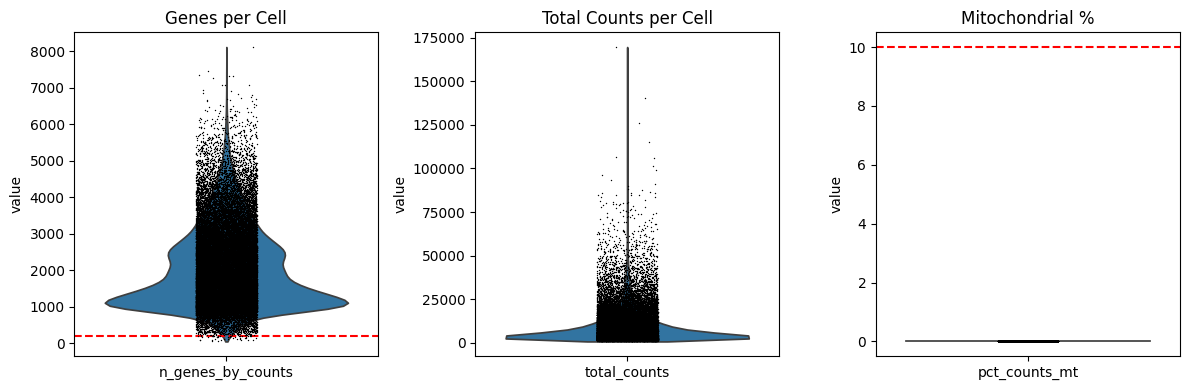

In [8]:
# Visualize QC metrics
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sc.pl.violin(adata, 'n_genes_by_counts', ax=axes[0], show=False)
axes[0].set_title('Genes per Cell')
axes[0].axhline(y=200, color='r', linestyle='--', label='Min threshold')

sc.pl.violin(adata, 'total_counts', ax=axes[1], show=False)
axes[1].set_title('Total Counts per Cell')

sc.pl.violin(adata, 'pct_counts_mt', ax=axes[2], show=False)
axes[2].set_title('Mitochondrial %')
axes[2].axhline(y=10, color='r', linestyle='--', label='Max threshold')

plt.tight_layout()
plt.show()

In [9]:
# Apply QC filters (same as PBMC)
n_before = adata.n_obs

sc.pp.filter_cells(adata, min_genes=200)
adata = adata[adata.obs.pct_counts_mt < 10, :].copy()
sc.pp.filter_genes(adata, min_cells=3)

n_after = adata.n_obs
print(f"Cells before QC: {n_before}")
print(f"Cells after QC: {n_after}")
print(f"Cells removed: {n_before - n_after} ({100*(n_before-n_after)/n_before:.1f}%)")
print(f"Genes after filtering: {adata.n_vars}")

filtered out 41 cells that have less than 200 genes expressed


filtered out 4698 genes that are detected in less than 3 cells


Cells before QC: 41688
Cells after QC: 41647
Cells removed: 41 (0.1%)
Genes after filtering: 18735


## 4. Normalization and HVG Selection

Match PBMC preprocessing:
- Normalize to 10,000 counts per cell
- Log transform
- Select 2000 highly variable genes (Seurat v3 method)

In [10]:
with Timer("Normalization and HVG selection"):
    # Normalize
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    # Store normalized data
    adata.raw = adata
    
    # HVG selection (Seurat v3 method, same as PBMC)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat_v3', layer='counts')
    
    print(f"Highly variable genes: {adata.var['highly_variable'].sum()}")
    
    # Subset to HVGs
    adata = adata[:, adata.var.highly_variable].copy()

print(f"\nFinal shape: {adata.shape}")

[Normalization and HVG selection] Starting at 01:18:14
normalizing counts per cell


    finished (0:00:00)


extracting highly variable genes


Highly variable genes: 2000


[Normalization and HVG selection] Completed in 4.18 seconds

Final shape: (41647, 2000)


## 5. Clustering

Same pipeline as PBMC:
- PCA (50 components)
- k-NN graph (k=15)
- UMAP embedding
- Leiden clustering (resolution=0.5)

In [11]:
with Timer("Clustering"):
    # Scale for PCA
    sc.pp.scale(adata, max_value=10)
    
    # PCA
    sc.tl.pca(adata, n_comps=50, svd_solver='arpack')
    
    # Neighbors
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
    
    # UMAP
    sc.tl.umap(adata)
    
    # Leiden clustering
    sc.tl.leiden(adata, resolution=0.5, key_added='leiden')

print(f"\nNumber of clusters: {adata.obs['leiden'].nunique()}")
print("\nCluster sizes:")
print(adata.obs['leiden'].value_counts().sort_index())

[Clustering] Starting at 01:18:19


/Users/dbenson/.pyenv/versions/3.12.3/lib/python3.12/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


computing PCA


    with n_comps=50


    finished (0:00:12)


computing neighbors


    using 'X_pca' with n_pcs = 30


2026-01-24 01:19:11.812611: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


    finished (0:00:47)


computing UMAP


    finished (0:00:42)


running Leiden clustering


/var/folders/d2/m4n149n97dn9rk26s76g_y_r0000gn/T/ipykernel_21296/2346832884.py:15: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5, key_added='leiden')


    finished (0:00:32)


[Clustering] Completed in 135.81 seconds

Number of clusters: 35

Cluster sizes:
leiden
0     6775
1     4158
2     3317
3     1804
4     1747
5     1538
6     1343
7     1328
8     1228
9     1209
10    1205
11    1199
12    1160
13    1114
14    1073
15    1001
16     966
17     964
18     911
19     900
20     873
21     822
22     653
23     610
24     486
25     484
26     457
27     437
28     394
29     394
30     365
31     353
32     261
33      97
34      21
Name: count, dtype: int64


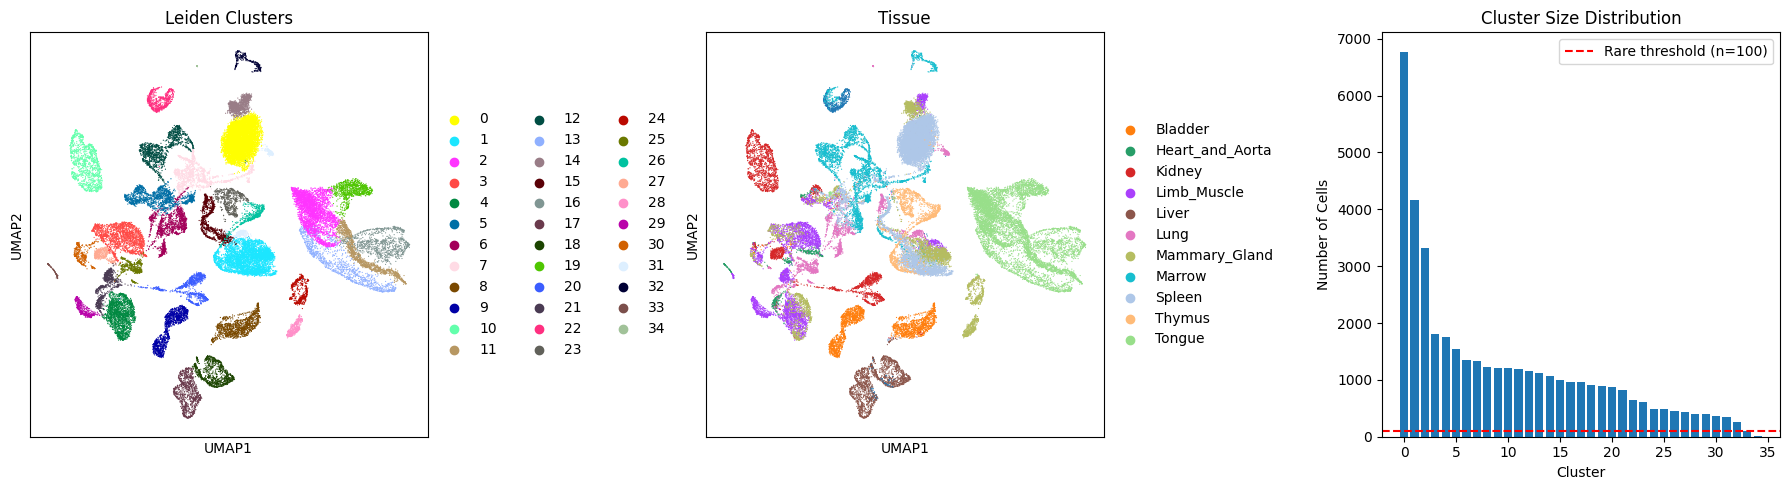

In [12]:
# Visualize clusters
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# UMAP by cluster
sc.pl.umap(adata, color='leiden', ax=axes[0], show=False, title='Leiden Clusters')

# UMAP by tissue
sc.pl.umap(adata, color='tissue', ax=axes[1], show=False, title='Tissue')

# Cluster size distribution
cluster_counts = adata.obs['leiden'].value_counts().sort_index()
axes[2].bar(range(len(cluster_counts)), cluster_counts.values)
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Number of Cells')
axes[2].set_title('Cluster Size Distribution')
axes[2].axhline(y=100, color='r', linestyle='--', label='Rare threshold (n=100)')
axes[2].legend()

plt.tight_layout()
plt.savefig('../figures/tabula_muris_clusters.png', dpi=150)
plt.show()

## 6. Identify Rare Clusters

Find clusters with < 100 cells for structured forget set candidates.

In [13]:
cluster_counts = adata.obs['leiden'].value_counts().sort_values()

print("All clusters by size:")
for cluster, count in cluster_counts.items():
    marker = "<-- RARE" if count < 100 else ""
    print(f"  Cluster {cluster}: {count:5d} cells {marker}")

rare_clusters = cluster_counts[cluster_counts < 100]
print(f"\n\nRare clusters (n < 100): {list(rare_clusters.index)}")
print(f"Total rare cells: {rare_clusters.sum()}")

# For comparison with PBMC (cluster 13 = 35 cells)
clusters_under_50 = cluster_counts[cluster_counts <= 50]
print(f"\nClusters with <= 50 cells (comparable to PBMC cluster 13):")
for cluster, count in clusters_under_50.items():
    print(f"  Cluster {cluster}: {count} cells")

All clusters by size:
  Cluster 34:    21 cells <-- RARE
  Cluster 33:    97 cells <-- RARE
  Cluster 32:   261 cells 
  Cluster 31:   353 cells 
  Cluster 30:   365 cells 
  Cluster 29:   394 cells 
  Cluster 28:   394 cells 
  Cluster 27:   437 cells 
  Cluster 26:   457 cells 
  Cluster 25:   484 cells 
  Cluster 24:   486 cells 
  Cluster 23:   610 cells 
  Cluster 22:   653 cells 
  Cluster 21:   822 cells 
  Cluster 20:   873 cells 
  Cluster 19:   900 cells 
  Cluster 18:   911 cells 
  Cluster 17:   964 cells 
  Cluster 16:   966 cells 
  Cluster 15:  1001 cells 
  Cluster 14:  1073 cells 
  Cluster 13:  1114 cells 
  Cluster 12:  1160 cells 
  Cluster 11:  1199 cells 
  Cluster 10:  1205 cells 
  Cluster 9:  1209 cells 
  Cluster 8:  1228 cells 
  Cluster 7:  1328 cells 
  Cluster 6:  1343 cells 
  Cluster 5:  1538 cells 
  Cluster 4:  1747 cells 
  Cluster 3:  1804 cells 
  Cluster 2:  3317 cells 
  Cluster 1:  4158 cells 
  Cluster 0:  6775 cells 


Rare clusters (n < 100): 

In [14]:
# Check tissue and cell type composition of rare clusters
print("Rare cluster composition:")
for cluster in rare_clusters.index:
    cluster_cells = adata.obs[adata.obs['leiden'] == cluster]
    print(f"\n=== Cluster {cluster} ({len(cluster_cells)} cells) ===")
    
    # Tissue distribution
    tissue_dist = cluster_cells['tissue'].value_counts()
    print("Tissues:")
    for tissue, count in tissue_dist.head(3).items():
        if tissue:  # Skip empty
            print(f"  {tissue}: {count}")
    
    # Cell type distribution (if available)
    if 'cell_ontology_class' in cluster_cells.columns:
        valid_cells = cluster_cells[cluster_cells['cell_ontology_class'] != '']
        if len(valid_cells) > 0:
            type_dist = valid_cells['cell_ontology_class'].value_counts()
            print("Cell types:")
            for ct, count in type_dist.head(3).items():
                print(f"  {ct}: {count}")

Rare cluster composition:

=== Cluster 34 (21 cells) ===
Tissues:
  Lung: 21
  Bladder: 0
Cell types:
  alveolar macrophage: 21
  : 0
  macrophage: 0

=== Cluster 33 (97 cells) ===
Tissues:
  Heart_and_Aorta: 60
  Limb_Muscle: 35
Cell types:
  cardiac muscle cell: 60
  : 0
  macrophage: 0


## 7. Save Processed Data

In [15]:
# Convert categorical/object columns to strings for h5ad compatibility
for col in adata.obs.columns:
    if adata.obs[col].dtype.name == 'category':
        adata.obs[col] = adata.obs[col].astype(str)
    elif adata.obs[col].dtype == object:
        adata.obs[col] = adata.obs[col].fillna('').astype(str)

# Save processed data
adata.write_h5ad(PROCESSED_PATH)
print(f"Saved processed data to {PROCESSED_PATH}")
print(f"\nFinal shape: {adata.shape}")
print(f"Number of clusters: {adata.obs['leiden'].nunique()}")

Saved processed data to ../data/tabula_muris_processed.h5ad

Final shape: (41647, 2000)
Number of clusters: 35


## Summary

| Metric | PBMC-33k | Tabula Muris |
|--------|----------|---------------|
| Cells (after QC) | 33,088 | TBD |
| HVGs | 2,000 | 2,000 |
| Clusters | 14 | TBD |
| Rare cluster for forget set | Cluster 13 (35 megakaryocytes) | TBD |

**Structured forget set candidate:** The smallest rare cluster with a biologically coherent cell type.

**Next:** `12_tabula_muris_baseline.ipynb` - Create train/unseen splits, train baseline VAE, evaluate MIA.